# References

* Build VGG16: https://www.youtube.com/watch?v=oDHpqu52soI&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=13
* Train VGG16: https://www.youtube.com/watch?v=INaX55V1zpY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14
* Predict VGG16: https://www.youtube.com/watch?v=HDom7mAxCdc&index=15&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL

In [519]:
!tree candd

candd
├── test
│   ├── cat
│   │   ├── 140.jpg
│   │   ├── 156.jpg
│   │   ├── 157.jpg
│   │   ├── 162.jpg
│   │   └── 163.jpg
│   └── dog
│       ├── 1040.jpg
│       ├── 1048.jpg
│       ├── 1070.jpg
│       ├── 146.jpg
│       └── 147.jpg
├── train
│   ├── cat
│   │   ├── 10.jpg
│   │   ├── 100.jpg
│   │   ├── 103.jpg
│   │   ├── 104.jpg
│   │   ├── 107.jpg
│   │   ├── 11.jpg
│   │   ├── 114.jpg
│   │   ├── 115.jpg
│   │   ├── 116.jpg
│   │   ├── 117.jpg
│   │   ├── 121.jpg
│   │   ├── 122.jpg
│   │   ├── 123.jpg
│   │   ├── 124.jpg
│   │   ├── 12479.jpg
│   │   ├── 128.jpg
│   │   ├── 129.jpg
│   │   ├── 13.jpg
│   │   ├── 15.jpg
│   │   └── 16.jpg
│   └── dog
│       ├── 1003.jpg
│       ├── 1006.jpg
│       ├── 1007.jpg
│       ├── 1010.jpg
│       ├── 1014.jpg
│       ├── 1019.jpg
│       ├── 102.jpg
│       ├── 1037.jpg
│       ├── 1038.jpg
│       ├── 1044.jpg
│       ├── 1053.jpg
│       ├── 1059.jpg
│       ├── 1067.jpg
│       ├── 1068.jpg
│       ├── 112.jpg
│       ├── 11

# Imports

In [520]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [521]:
# https://github.com/smileservices/keras_utils/blob/master/utils.py
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [522]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Setup

In [523]:
# https://www.kaggle.com/c/dogs-vs-cats/data
# train_path = 'cats-and-dogs-demo/train' # 20
# valid_path = 'cats-and-dogs-demo/valid' # 8
# test_path = 'cats-and-dogs-demo/test'   # 5

train_path = 'candd/train' # 20
valid_path = 'candd/valid' # 8
test_path = 'candd/test'   # 5

In [524]:
# https://keras.io/preprocessing/image/
# 20
train_batches = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=True
)

Found 40 images belonging to 2 classes.


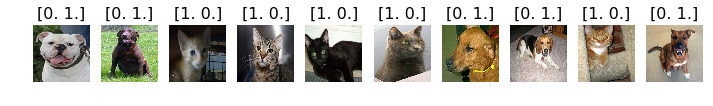

In [525]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [526]:
# 8
valid_batches = ImageDataGenerator().flow_from_directory(
    valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=4, shuffle=True
)

Found 16 images belonging to 2 classes.


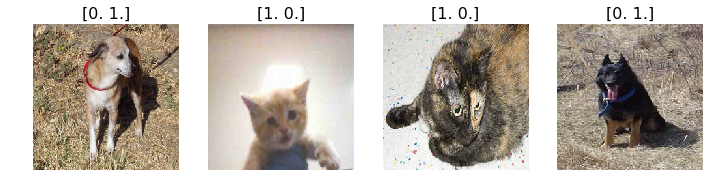

In [527]:
valid_imgs, valid_labels = next(valid_batches)
plots(valid_imgs, titles=valid_labels)

# Build Fine-Tuned VGG16 Model

In [528]:
vgg16_model = keras.applications.vgg16.VGG16()

In [529]:
# vgg16_model.summary()

In [530]:
type(vgg16_model)

keras.engine.training.Model

In [531]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [532]:
# model.summary()

In [533]:
# model.layers.pop()
# should remove the last layer but there is a bug in the current model implementation,
# so we simply don't add the last layer to this model (see for loop above)

In [534]:
# model.summary()

In [535]:
# Existing layers in VGG16 have been trained on images so we dont want to do that again. Only train the last layer.
for layer in model.layers:
    layer.trainable = False

In [536]:
model.add(Dense(2, activation='softmax'))

In [537]:
# model.summary()

In [538]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Fine-Tuned VGG16 Model

In [539]:
model.fit_generator(
    train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=1
)

Epoch 1/5
4/4 [==============================] - 27s 7s/step - loss: 1.8547 - acc: 0.4000 - val_loss: 1.8566 - val_acc: 0.2500
Epoch 2/5
4/4 [==============================] - 27s 7s/step - loss: 1.2691 - acc: 0.4750 - val_loss: 0.6335 - val_acc: 0.5625
Epoch 3/5
4/4 [==============================] - 28s 7s/step - loss: 0.9806 - acc: 0.5750 - val_loss: 1.0437 - val_acc: 0.5000
Epoch 4/5
4/4 [==============================] - 30s 7s/step - loss: 0.7369 - acc: 0.6000 - val_loss: 0.7822 - val_acc: 0.6250
Epoch 5/5
4/4 [==============================] - 35s 9s/step - loss: 0.4546 - acc: 0.8250 - val_loss: 0.5095 - val_acc: 0.8125


# Setup Test Batches

In [540]:
# 5
test_batches = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=5, shuffle=False
)

Found 10 images belonging to 2 classes.


# Setup Test 1

In [541]:
test_imgs, test_labels = next(test_batches)

In [542]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 1., 1., 1.], dtype=float32)

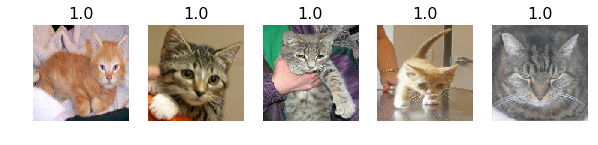

In [543]:
plots(test_imgs, titles=test_labels)

# Predict using Fine-Tuned VGG16 Model

In [544]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

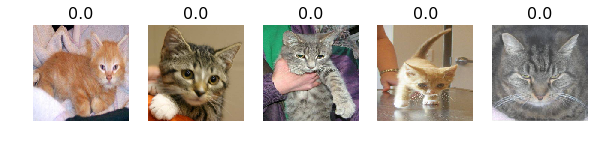

In [545]:
plots(test_imgs, titles=np.round(predictions[:,0]))

In [546]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[0 0]
 [5 0]]


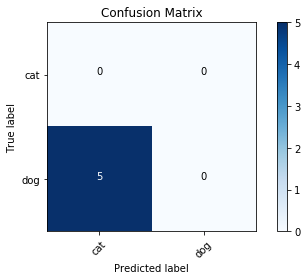

In [547]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Setup Test 2

In [548]:
test_imgs, test_labels = next(test_batches)

In [549]:
test_labels = test_labels[:,0]
test_labels

array([0., 0., 0., 0., 0.], dtype=float32)

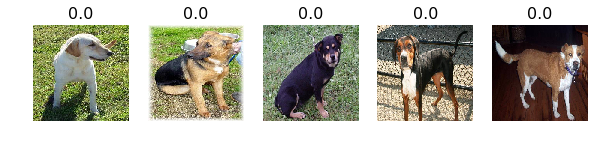

In [550]:
plots(test_imgs, titles=test_labels)

# Predict using Fine-Tuned VGG16 Model

In [551]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

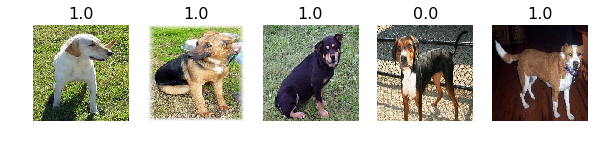

In [552]:
plots(test_imgs, titles=np.round(predictions[:,0]))

In [553]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[1 4]
 [0 0]]


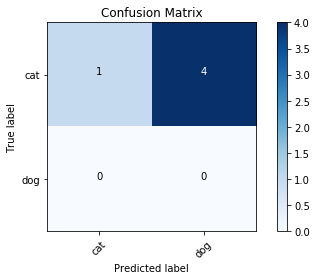

In [554]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Setup

In [555]:
model.save('cats-and-dogs_20-8-5_VGG16.h5')